# Setup

Install required packages (only needed once per environment).  
Packages used:

- `transformers` (Hugging Face) for pretrained models and pipelines
- `torch` as backend for Transformer models
- `pandas`, `numpy` for data wrangling
- `scikit-learn` for metrics and train/test split
- `matplotlib` for plots


In [43]:
!pip install --upgrade pip
!pip install numpy pandas matplotlib scikit-learn transformers torch --extra-index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cpu


In [44]:
import os, re, math, random, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

from transformers import pipeline
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import torch
import torch.nn.functional as F

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Path to  dataset file
DATA_PATH = "archive (5)/smile-annotations-final.csv"

print("Using data file:", DATA_PATH)

Using data file: archive (5)/smile-annotations-final.csv


# Load Data & Quick EDA

Load the SMILE dataset, show basic info, and preview a few rows to understand columns.


In [45]:
df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
print("\nColumns:", list(df.columns))
print("\nHead:")
display(df.head(10))

Shape: (3084, 3)

Columns: ['611857364396965889', '@aandraous @britishmuseum @AndrewsAntonio Merci pour le partage! @openwinemap', 'nocode']

Head:


,611857364396965889,@aandraous @britishmuseum @AndrewsAntonio Merci pour le partage! @openwinemap,nocode
0,614484565059596288,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy
1,614746522043973632,@SelectShowcase @Tate_StIves ... Replace with ...,happy
2,614877582664835073,@Sofabsports thank you for following me back. ...,happy
3,611932373039644672,@britishmuseum @TudorHistory What a beautiful ...,happy
4,611570404268883969,@NationalGallery @ThePoldarkian I have always ...,happy
5,614456889863208960,"@britishmuseum say wot, mate?",nocode
6,614016385442807809,Two workshops on evaluating audience engagemen...,nocode
7,610916556751642624,"A Forest Road, by Thomas Gainsborough 1750 Oil...",nocode
8,614499696015503361,Lucky @FitzMuseum_UK! Good luck @MirandaStearn...,happy
9,612869223354925056,"""1...2..."" ""non arrête mon brush!"". l.Alma|A f...",nocode


### Rename and adjust columns 

In [46]:

# Rename columns and drop id column
df_sent = df.rename(columns={'611857364396965889': 'id', '@aandraous @britishmuseum @AndrewsAntonio Merci pour le partage! @openwinemap': 'text', 'nocode': 'category'}) 
df_sent.drop('id', axis=1, inplace=True)

print("\nSample rows after renaming:")
display(df_sent.sample(5, random_state=RANDOM_SEED))
print("\n", df_sent.info())


Sample rows after renaming:


,text,category
1505,Year 4 @britishmuseum checking out some Ancien...,happy
2398,@DavidSmithArt @roshvarosha @LisaLooly @newman...,happy
1814,Start your @_TheWhitechapel #FirstThursday at ...,nocode
511,Project curator sought for South Africa exhibi...,not-relevant
1565,See all the photos from Wednesday's #Defeating...,nocode


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3084 entries, 0 to 3083
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      3084 non-null   object
 1   category  3084 non-null   object
dtypes: object(2)
memory usage: 48.3+ KB

 None


# Preprocess: Clean Text 

Clean the text (lowercase, strip URLs/mentions/hashtags).


In [47]:
URL_RE = re.compile(r"http\S+|www\.\S+")
MENTION_RE = re.compile(r"@\w+")
HASHTAG_RE = re.compile(r"#(\w+)")
MULTISPACE_RE = re.compile(r"\s+")

def clean_text(s: str) -> str:
    s = s.lower()
    s = URL_RE.sub("", s)
    s = MENTION_RE.sub("", s)
    s = HASHTAG_RE.sub(r"\1", s)  # keep hashtag word
    s = re.sub(r"[^\x00-\x7F]+", " ", s)  # drop non-ascii (quick/simple)
    s = MULTISPACE_RE.sub(" ", s).strip()
    return s

df_sent['text'] = df_sent["text"].astype(str).apply(clean_text)
df_sent


,text,category
0,dorian gray with rainbow scarf lovewins (from,happy
1,... replace with your wish which the artist us...,happy
2,thank you for following me back. great to hear...,happy
3,what a beautiful jewel / portrait. is the 'r' ...,happy
4,i have always loved this painting.,happy
...,...,...
3079,mt : looking forward to our public engagement ...,happy
3080,upper arm guard?,nocode
3081,mesmerising.,happy
3082,the 2nd genocide against biafrans as promised ...,not-relevant


# Build Two Sentiment Pipelines

Build two Hugging Face `pipeline` objects.

- Model A: `distilbert-base-uncased-finetuned-sst-2-english` (binary: POSITIVE/NEGATIVE).
- Model B: `cardiffnlp/twitter-roberta-base-sentiment-latest` (ternary: NEGATIVE/NEUTRAL/POSITIVE).  
  We will post-process so both return one of {NEGATIVE, NEUTRAL, POSITIVE}.

In [102]:
model_a = "distilbert-base-uncased-finetuned-sst-2-english"  
model_b = "cardiffnlp/twitter-roberta-base-sentiment-latest" 

# Set up piplines and tokenizers
tokenizer_a = AutoTokenizer.from_pretrained(model_a)
tokenizer_b = AutoTokenizer.from_pretrained(model_b)
MODEL_a = AutoModelForSequenceClassification.from_pretrained(model_a)
MODEL_b = AutoModelForSequenceClassification.from_pretrained(model_b)
clf_a = pipeline('sentiment-analysis', model=model_a, tokenizer=tokenizer_a, max_length=492, truncation=True) # returns label/score
clf_b = pipeline('sentiment-analysis', model=model_b, tokenizer=tokenizer_b, max_length=492,  truncation=True)
print("piplines ready")

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing Robe

piplines ready


## Map Emotions Using Pipline

In [49]:
# Specify emotion/category values to roBERTa pipe sentiment labels
emotions_labels = (df_sent['category'].unique())
map_sentiment = []
for e in emotions_labels:
    sent_pred = clf_b(e)[0]['label']
    map_sentiment.append(sent_pred)

emotion_to_sentiment = dict(zip(emotions_labels, map_sentiment))

# Map emotions to sentiment for dataset
df_sent['sentiment'] = df_sent['category'].map(emotion_to_sentiment)
labels = ['negative', 'neutral', 'positive']
df_sent

,text,category,sentiment
0,dorian gray with rainbow scarf lovewins (from,happy,positive
1,... replace with your wish which the artist us...,happy,positive
2,thank you for following me back. great to hear...,happy,positive
3,what a beautiful jewel / portrait. is the 'r' ...,happy,positive
4,i have always loved this painting.,happy,positive
...,...,...,...
3079,mt : looking forward to our public engagement ...,happy,positive
3080,upper arm guard?,nocode,neutral
3081,mesmerising.,happy,positive
3082,the 2nd genocide against biafrans as promised ...,not-relevant,neutral


# Run Individual Prediction Examples

In [93]:
# Create individual sentence predictor function
def pipe_predict(text, column, pipe):
    sent_list = []
    score_list = []
    for i in text[column]:
        sent_label = pipe(i)[0]['label']
        sent_score = pipe(i)[0]['score']
        sent_list.append(sent_label)
        score_list.append(sent_score)

    text['sentiment'] = sent_list
    text['score'] = score_list
    return(text) 

df_samples = df_sent.sample(5, random_state=RANDOM_SEED)

### Distilbert model sentiment labeling

In [95]:
pipe_predict(df_samples, 'text', clf_a)

,text,category,sentiment,score
1505,year 4 checking out some ancient egypt artefac...,happy,POSITIVE,0.995177
2398,thank you :-),happy,POSITIVE,0.999824
1814,start your firstthursday at ceviche old st gal...,nocode,NEGATIVE,0.978847
511,project curator sought for south africa exhibi...,not-relevant,POSITIVE,0.628066
1565,see all the photos from wednesday's defeatingd...,nocode,NEGATIVE,0.936161


### RoBERTa model sentiment labeling

In [96]:
pipe_predict(df_samples, 'text', clf_b)

,text,category,sentiment,score
1505,year 4 checking out some ancient egypt artefac...,happy,positive,0.918723
2398,thank you :-),happy,positive,0.953553
1814,start your firstthursday at ceviche old st gal...,nocode,neutral,0.811932
511,project curator sought for south africa exhibi...,not-relevant,neutral,0.921039
1565,see all the photos from wednesday's defeatingd...,nocode,neutral,0.901342


As we can see our Hugging Face models are operational and the pipelines are producing sentiment labels as expected. As the documentation indicates, model text predictions output three sentiment labels `POSITIVE` , `NEGATIVE` or `NEUTRAL` and their respective confidence scores.

# Dataset Predictions - Model Specific

Implemented hugging face models require speific tokenized attributes specific to the model used for predicting. We will create two prediction funcitons 
for each model. 

In [ ]:
# Create distilbert prediction funciton
def predict_distilbert(text_data):

    # Tokenize text
    inputs = tokenizer_a(text_data, return_tensors="pt", truncation=True)

    # Disable gradient calculation
    with torch.no_grad():
        outputs = MODEL_a(**inputs)
    # Get softmax probabilities
    probs = F.softmax(outputs.logits, dim=1)

    # Get predicted sentiment and score
    predicted_class_idx = torch.argmax(probs, dim=1).item()
    predicted_label = labels[predicted_class_idx]
    confidence_score = probs[0][predicted_class_idx].item()

    return predicted_label, confidence_score


In [ ]:
# Apply function
df_distil = df_sent.copy()
df_distil[['predicted_sentiment', 'score']] = df_sent['text'].apply(
    lambda x: pd.Series(predict_distilbert(x)))

In [104]:
# Create roBERTa prediction funciton
def predict_roberta(text_data):

    # Tokenize text
    inputs = tokenizer_b(text_data, return_tensors="pt", max_length=492, truncation=True)

    # Disable gradient calculation
    with torch.no_grad():
        outputs = MODEL_b(**inputs)
    # Get softmax probabilities
    probs = F.softmax(outputs.logits, dim=1)

    # Get predicted sentiment and score
    predicted_class_idx = torch.argmax(probs, dim=1).item()
    predicted_label = labels[predicted_class_idx]
    confidence_score = probs[0][predicted_class_idx].item()

    return predicted_label, confidence_score

In [105]:
# Apply function
df_roberta = df_sent.copy()
df_roberta[['predicted_sentiment', 'score']] = df_sent['text'].apply(
    lambda x: pd.Series(predict_roberta(x)))

# Evaluate Models

In [68]:
# Create eval function
def evaluate_model(dataset):
    acc = accuracy_score(dataset['sentiment'], dataset['predicted_sentiment'])
    f1m = f1_score(dataset['sentiment'], dataset['predicted_sentiment'], average="macro")
    print(f"Accuracy: {acc:.4f} | Macro-F1: {f1m:.4f}\n")
    print(classification_report(dataset['sentiment'], dataset['predicted_sentiment'], digits=4))

    # Confidence histogram
    plt.figure()
    plt.hist(dataset['score'], bins=20)
    plt.title(f"model — Prediction Confidence")
    plt.xlabel("confidence")
    plt.ylabel("count")
    plt.show()

    # Predicted distribution
    pd.Series(dataset['predicted_sentiment']).value_counts().plot(kind="bar")
    plt.title(f"model — Predicted label distribution")
    plt.xlabel("label")
    plt.ylabel("count")
    plt.show()

    return acc, f1m

### Model 'distilbert-base-uncased-finetuned-sst-2-english', eval

Accuracy: 0.3865 | Macro-F1: 0.2443

              precision    recall  f1-score   support

    negative     0.1003    0.8411    0.1793       107
     neutral     0.5039    0.6143    0.5536      1794
    positive     0.0000    0.0000    0.0000      1183

    accuracy                         0.3865      3084
   macro avg     0.2014    0.4851    0.2443      3084
weighted avg     0.2966    0.3865    0.3283      3084



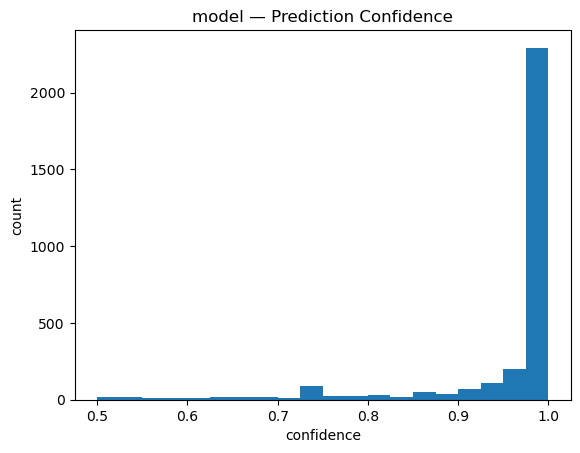

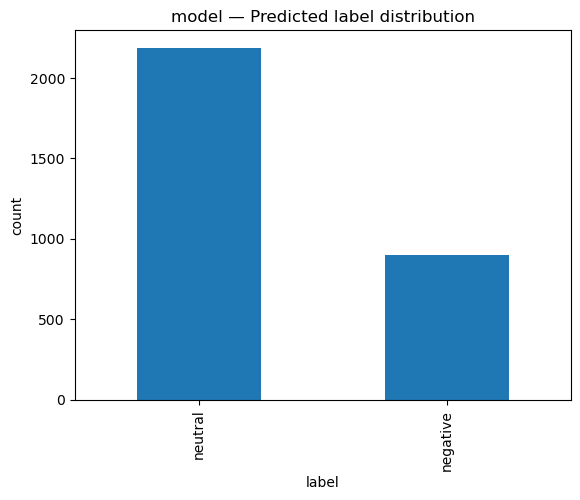

In [73]:
# Evaluate distilbert predictions
dis_acc, dis_f1m = evaluate_model(df_distil)

### Model 'cardiffnlp/twitter-roberta-base-sentiment-latest', eval

Accuracy: 0.8116 | Macro-F1: 0.6848

              precision    recall  f1-score   support

    negative     0.3081    0.5327    0.3904       107
     neutral     0.9025    0.7787    0.8360      1794
    positive     0.7765    0.8867    0.8279      1183

    accuracy                         0.8116      3084
   macro avg     0.6623    0.7327    0.6848      3084
weighted avg     0.8335    0.8116    0.8175      3084



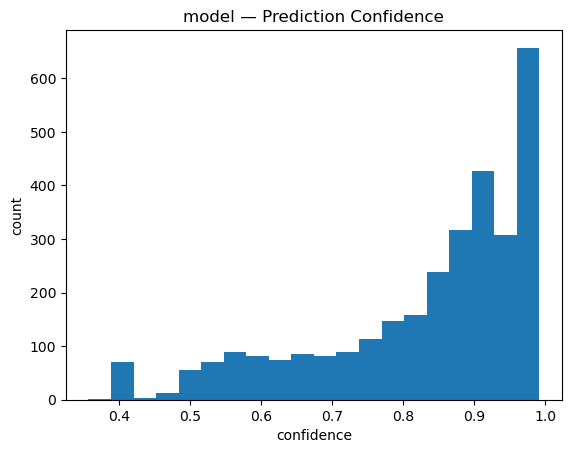

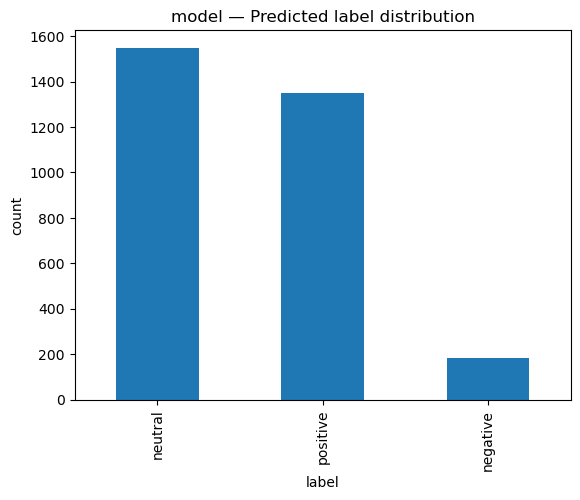

In [106]:
# Evaluate roberta predictions
rob_acc, rob_f1m = evaluate_model(df_roberta)

# Compare Model Metrics: Accuracy and F1 Macro

In [80]:
comp = pd.DataFrame( data={'Model': ['distilbert-base-uncased-finetuned-sst-2-english', 'cardiffnlp/twitter-roberta-base-sentiment-latest'], 'F1_macro': [dis_f1m, rob_f1m], 'Accuracy': [dis_acc, rob_acc]}).sort_values("F1_macro", ascending=False).reset_index(drop=True)
print("\nComparison (higher is better):")
display(comp)


Comparison (higher is better):


,Model,F1_macro,Accuracy
0,cardiffnlp/twitter-roberta-base-sentiment-latest,0.684792,0.811608
1,distilbert-base-uncased-finetuned-sst-2-english,0.244304,0.386511


Roberta model appears to perform better across F1 macro and Accuracy scores.

# Creative Application 

Apply a best performing model to a choosen domain (e.g., song lyrics, news headlines).  

In [81]:
# Import Billie Eilish lyrics dataset
df_billie = pd.read_csv("archive (5)/BillieEilish.csv")

In [91]:
# Clean data
df_billie['Lyric'] = df_billie["Lyric"].astype(str).apply(clean_text)
df_billie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  145 non-null    int64  
 1   Artist      145 non-null    object 
 2   Title       145 non-null    object 
 3   Album       82 non-null     object 
 4   Year        119 non-null    float64
 5   Date        119 non-null    object 
 6   Lyric       145 non-null    object 
dtypes: float64(1), int64(1), object(5)
memory usage: 8.1+ KB


In [ ]:
# Run Data lyrics through roBERTa prediction 
df_billie_rob = df_billie.copy()
df_billie_rob[['predicted_sentiment', 'score']] = df_billie['Lyric'].apply(
    lambda x: pd.Series(predict_roberta(x)))

In [108]:
# View predictions
df_billie_rob

,Unnamed: 0,Artist,Title,Album,Year,Date,Lyric,sentiment,score,predicted_sentiment
0,0,Billie Eilish,​when the party’s over,"WHEN WE ALL FALL ASLEEP, WHERE DO WE GO? (Japa...",2018.0,2018-10-17,don't you know i'm no good for you i've learne...,negative,0.682655,negative
1,1,Billie Eilish,​everything i wanted,"WHEN WE ALL FALL ASLEEP, WHERE DO WE GO? (Targ...",2019.0,2019-11-13,i had a dream i got everything i wanted not wh...,neutral,0.474398,neutral
2,2,Billie Eilish,​bad guy,"WHEN WE ALL FALL ASLEEP, WHERE DO WE GO? (Japa...",2019.0,2019-03-29,white shirt now red my bloody nose sleepin' yo...,negative,0.744881,negative
3,3,Billie Eilish,​idontwannabeyouanymore,dont smile at me,2017.0,2017-07-21,don't be that way fall apart twice a day i jus...,negative,0.636411,negative
4,4,Billie Eilish,​bury a friend,"WHEN WE ALL FALL ASLEEP, WHERE DO WE GO? (Japa...",2019.0,2019-01-30,mehki raine billie billie eilish what do you w...,negative,0.592910,negative
...,...,...,...,...,...,...,...,...,...,...
140,140,Billie Eilish,​come out and play (Live at Third Man Records),Live at Third Man Records,2019.0,2019-12-06,that's right alright oh we back okay you ready...,positive,0.891490,positive
141,141,Billie Eilish,​idontwannabeyouanymore (Live at Third Man Rec...,Live at Third Man Records,2019.0,2019-12-06,thank you teeheehee ah this is aan oldie mm ba...,neutral,0.419311,neutral
142,142,Billie Eilish,​bellyache (Live at Third Man Records),Live at Third Man Records,2019.0,2019-12-06,uhuhuh dadadadada sittin' all alone mouth full...,neutral,0.537655,neutral
143,143,Billie Eilish,COPYCAT (Live at Third Man Records),Live at Third Man Records,2019.0,2019-12-06,ooh mm don't be cautious don't be kind you com...,negative,0.705395,negative


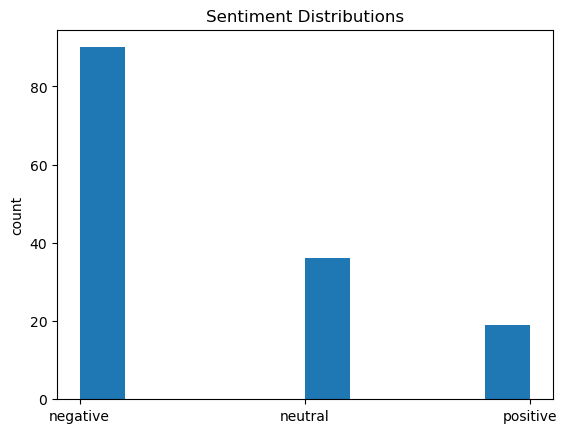

In [112]:
# Plot sentiment distribution by year

plt.figure()
plt.hist(df_billie_rob['predicted_sentiment'])
plt.title(f"Sentiment Distributions")
plt.ylabel("count")
plt.show()

# Conclusion

**What we accomplished:**

- Built a complete **sentiment analysis** workflow with two pretrained models.
- Evaluated with **accuracy, macro-F1**, and confusion matrices.
- Visualized **confidence** and **label distributions**.
- Created a reusable **prediction function** and applied it to a new domain.

**Next steps:**

- Collect more domain-specific labeled data and try the fine-tuning section.
- Explore more models in the Hugging Face Hub (larger RoBERTa/BERT variants).
